In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.utils import np_utils
import sklearn.metrics as metrics
import tensorflowjs as tfjs


In [181]:
train = pd.read_csv("emnist/emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("emnist/emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("emnist/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))




Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [182]:
HEIGHT = 28
WIDTH = 28

In [183]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [184]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [185]:
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [186]:

train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

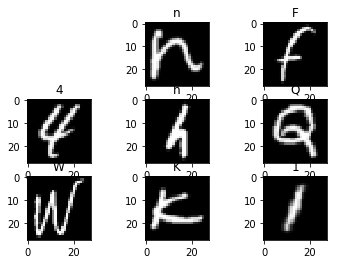

In [187]:
for i in range(1, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    
    plt.title(chr(mapp[train_y[i]]))

In [188]:
num_classes = len(set(train_y))
num_classes

47

In [189]:
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [190]:
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)



In [191]:
train_x.shape


(112799, 28, 28, 1)

In [192]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)




# CNN

In [197]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=2000, activation='relu'))
model.add(Dropout(.07))
model.add(Dense(units=1500, activation='relu'))
model.add(Dropout(.05))

model.add(Dense(units=1000, activation='relu'))
model.add(Dense(units=700, activation='relu'))
model.add(Dropout(.05))


model.add(Dense(units=700, activation='relu'))

model.add(Dropout(.05))

model.add(Dense(units=400, activation='relu'))

model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=130, activation='relu'))
model.add(Dropout(.1))

model.add(Dense(units=70, activation='relu'))


model.add(Dense(units=num_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 2000)              6274000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 2000)              0         
__________

In [198]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Cnn

In [199]:
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))


Train on 101519 samples, validate on 11280 samples
Epoch 1/10
101519/101519 [==============================] - 331s 3ms/step - loss: 1.5185 - acc: 0.5486 - val_loss: 0.6358 - val_acc: 0.7860
Epoch 2/10
101519/101519 [==============================] - 356s 4ms/step - loss: 0.5131 - acc: 0.8294 - val_loss: 0.4348 - val_acc: 0.8527
Epoch 3/10
101519/101519 [==============================] - 347s 3ms/step - loss: 0.3995 - acc: 0.8662 - val_loss: 0.3982 - val_acc: 0.8603
Epoch 4/10
101519/101519 [==============================] - 358s 4ms/step - loss: 0.3546 - acc: 0.8777 - val_loss: 0.4015 - val_acc: 0.8695
Epoch 5/10
101519/101519 [==============================] - 359s 4ms/step - loss: 0.3219 - acc: 0.8869 - val_loss: 0.3920 - val_acc: 0.8676
Epoch 6/10
101519/101519 [==============================] - 364s 4ms/step - loss: 0.2937 - acc: 0.8943 - val_loss: 0.3912 - val_acc: 0.8714
Epoch 7/10
101519/101519 [==============================] - 355s 3ms/step - loss: 0.2724 - acc: 0.9015 - val_

In [200]:

def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()



In [201]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)


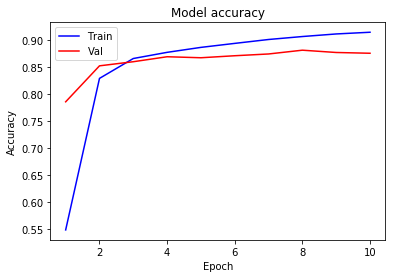

In [202]:
plotgraph(epochs, acc, val_acc)


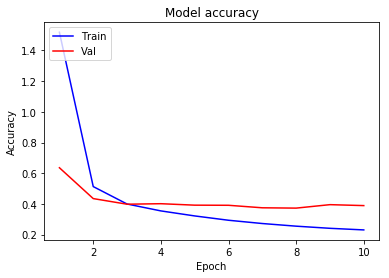

In [203]:
plotgraph(epochs, loss, val_loss)


In [215]:
scores = model.evaluate(train_x, train_y)

101519/101519 [==============================] - 97s 958us/step


In [216]:
print ("[INFO] test score - {}".format(scores[0]))
print ("[INFO] test accuracy - {}".format(scores[1]))


[INFO] test score - 0.2070744130001018
[INFO] test accuracy - 0.9219751967617845


In [214]:
model_save_path     = "output/cnn"


tfjs.converters.save_keras_model(model, model_save_path)



In [210]:
def run_prediction(idx):
    result = np.argmax(model.predict(test_x[idx:idx+1]))
    print('Prediction: ', result, ', Char: ', mapp[result])
    print("Label: ", np.argmax(test_y[idx:idx+1]))
    img=test_x[idx:idx+1].squeeze()
    return plt.imshow(img, cmap=plt.get_cmap('gray'))





In [211]:
def run_predictions(idx):
    result = np.argmax(model.predict(test_x[idx:idx+1]))
    print('Prediction: ', result, ', Char: ', mapp[result])
    print("Label: ", np.argmax(test_y[idx:idx+1]))
    img=test_x[idx:idx+1].squeeze()


In [212]:
import random

for _ in range(0,10):
    idx = random.randint(0, 47-1)
    run_predictions(idx)

Prediction:  12 , Char:  67
Label:  12
Prediction:  26 , Char:  81
Label:  44
Prediction:  26 , Char:  81
Label:  44
Prediction:  3 , Char:  51
Label:  3
Prediction:  8 , Char:  56
Label:  8
Prediction:  28 , Char:  83
Label:  28
Prediction:  4 , Char:  52
Label:  4
Prediction:  39 , Char:  101
Label:  39
Prediction:  6 , Char:  54
Label:  6
Prediction:  39 , Char:  101
Label:  39


Prediction:  39 , Char:  101
Label:  39


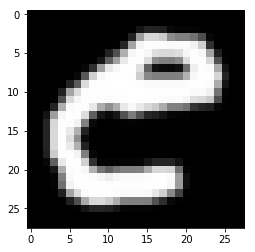

In [213]:
import random

for _ in range(1,2):
    idx = random.randint(0, 47-1)
    run_prediction(idx)
    
    